In [3]:
import torch  
import torch.nn as nn   
import torch.optim as optim  
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader  
import matplotlib.pyplot as plt  

In [4]:
transform = transforms.Compose([  
    transforms.Resize((32, 32)),  
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)) 
])  #处理数据的模式
#第一层卷积（5×5 kernel）：32×32 输入 → 28×28 输出（32-5+1=28）；
#第一层池化（2×2）：28×28 → 14×14；
#第二层卷积（5×5）：14×14 → 10×10；
#第二层池化（2×2）：10×10 → 5×5；

In [5]:
train_dataset = datasets.MNIST(  
    root="./data",  
    train=True,  
    download=True,  
    transform=transform  
)  
test_dataset = datasets.MNIST(  
    root="./data",  
    train=False,  
    download=True,  
    transform=transform  
)  

100.0%
100.0%
100.0%
100.0%


In [6]:
# batch_size=64：每次训练用64张图  
# shuffle=True：训练时打乱图片顺序
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # 测试不用打乱  

In [8]:
images, labels = next(iter(train_loader))  
print(f"一批图片的形状：{images.shape}")  # 64张图，1通道，32×32  
print(f"对应的标签形状：{labels.shape}")  # 64个标签

一批图片的形状：torch.Size([64, 1, 32, 32])
对应的标签形状：torch.Size([64])


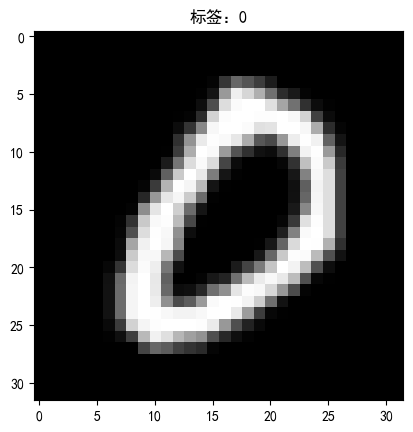

In [11]:
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.imshow(images[0].squeeze(), cmap="gray")  # squeeze()去掉通道维度，只留32×32  
plt.title(f"标签：{labels[0].item()}")  # 显示真实数字  
plt.show() 

In [ ]:
class LeNet5(nn.Module):  
    def __init__(self):  
        super(LeNet5, self).__init__()  

        # 第一部分：卷积层+池化层（提取特征，保留空间结构）  
        self.conv_part = nn.Sequential(  
            
            # C1层：卷积层 1通道 6卷积核5x5 滑动1像素 0填充  （提取边缘、拐角等低级特征）
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),  
            nn.Tanh(),  # 激活函数：把输出压缩到[-1,1]，增加非线性（让模型能学复杂特征）  

            # S2层：池化层  2×2的区域取平均 滑动2像素 
            nn.AvgPool2d(kernel_size=2, stride=2),  

            # C3层：卷积层 6通道 16卷积核5x5 滑动1像素 0填充（组合低级特征，提取更复杂的特征，比如“半圈”）  
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),  
            nn.Tanh(),  

            # S4层：池化层  
            nn.AvgPool2d(kernel_size=2, stride=2)  
        )  

        # 第二部分：全连接层（整合特征，输出分类结果）  
        self.fc_part = nn.Sequential(  
            # C5层：全连接层  S4的输出是16通道5×5的特征图，展平后是16×5×5=400 输出120个特征 
            nn.Linear(in_features=16*5*5, out_features=120),  
            nn.Tanh(),  

            # F6层：全连接层（进一步提炼特征）  
            nn.Linear(in_features=120, out_features=84),  
            nn.Tanh(),  

            # 输出层：10个神经元（对应0-9），不激活（后面用CrossEntropyLoss，自带softmax）  
            nn.Linear(in_features=84, out_features=10)  
        )  
  
    def forward(self, x):  
        x = self.conv_part(x)  # 卷积和池化 
        x = x.view(-1, 16*5*5)  # 展平：把16×5×5的特征图转成1×400的向量 
        x = self.fc_part(x)  # 全连接 
        return x  # 输出10个logits(原始分数)

In [ ]:
model = LeNet5()  

# 损失函数CrossEntropyLoss：自带softmax，直接用logits计算损失（适合分类问题）  
criterion = nn.CrossEntropyLoss()  

# momentum=0.9：动量（加速收敛，给梯度下降增加惯性）  
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  

In [ ]:
 
epochs = 10  # 训练10轮
train_losses = []  # 训练损失
train_accs = []  # 训练准确率  
  
for epoch in range(epochs):   
    model.train()  # 切换到训练模式
    running_loss = 0.0  # 记录本轮的总损失  
    correct = 0  # 记录本轮正确预测的数量  
    total = 0  # 记录本轮总样本数  
 
    for i, (images, labels) in enumerate(train_loader):  
        # 依旧清空梯度
        optimizer.zero_grad()  

        # 前向传播：用当前模型预测标签  
        outputs = model(images)  # 输出10个logits（形状[64,10]）  

        # 计算损失：预测结果和真实标签的差距  
        loss = criterion(outputs, labels)  

        # 反向传播：计算每个参数的梯度 
        loss.backward()  

        # 根据梯度更新参数
        optimizer.step()  

        # 记录损失和准确率  
        running_loss += loss.item()  # 累加损失（item()把张量转成数字）  

        # 计算准确率：取logits中最大值的位置作为预测标签  
        _, predicted = torch.max(outputs.data, 1)  # predicted是预测的标签（形状[64]）  
        total += labels.size(0)  # 累加总样本数（每批64个）  
        correct += (predicted == labels).sum().item()  # 累加正确的数量  

        # 每100个批次打印一次中间结果（看进度）  
        if (i + 1) % 100 == 0:  
            print(f"轮次 [{epoch+1}/{epochs}], 批次 [{i+1}/{len(train_loader)}], 损失: {loss.item():.4f}")  

    # 本轮训练结束，计算平均损失和准确率  
    avg_loss = running_loss / len(train_loader)  
    accuracy = 100 * correct / total  
    train_losses.append(avg_loss)  
    train_accs.append(accuracy)  

    print(f"轮次 {epoch+1}/{epochs} 结束：平均损失 = {avg_loss:.4f}, 准确率 = {accuracy:.2f}%")  

轮次 [1/10], 批次 [100/938], 损失: 0.6902
轮次 [1/10], 批次 [200/938], 损失: 0.3967
轮次 [1/10], 批次 [300/938], 损失: 0.3011
轮次 [1/10], 批次 [400/938], 损失: 0.4911
轮次 [1/10], 批次 [500/938], 损失: 0.1514
轮次 [1/10], 批次 [600/938], 损失: 0.2027
轮次 [1/10], 批次 [700/938], 损失: 0.1480
轮次 [1/10], 批次 [800/938], 损失: 0.1049
轮次 [1/10], 批次 [900/938], 损失: 0.2060
轮次 1/10 结束：平均损失 = 0.3894, 准确率 = 88.67%
轮次 [2/10], 批次 [100/938], 损失: 0.0800
轮次 [2/10], 批次 [200/938], 损失: 0.0816
轮次 [2/10], 批次 [300/938], 损失: 0.0626
轮次 [2/10], 批次 [400/938], 损失: 0.0955
轮次 [2/10], 批次 [500/938], 损失: 0.0506
轮次 [2/10], 批次 [600/938], 损失: 0.0423
轮次 [2/10], 批次 [700/938], 损失: 0.1146
轮次 [2/10], 批次 [800/938], 损失: 0.0294
轮次 [2/10], 批次 [900/938], 损失: 0.1054
轮次 2/10 结束：平均损失 = 0.0922, 准确率 = 97.24%
轮次 [3/10], 批次 [100/938], 损失: 0.0167
轮次 [3/10], 批次 [200/938], 损失: 0.1771
轮次 [3/10], 批次 [300/938], 损失: 0.0112
轮次 [3/10], 批次 [400/938], 损失: 0.0192
轮次 [3/10], 批次 [500/938], 损失: 0.0645
轮次 [3/10], 批次 [600/938], 损失: 0.0154
轮次 [3/10], 批次 [700/938], 损失: 0.0377
轮次 [3/10], 批次 [800/938

In [ ]:
model.eval()  # 切换到测试模式
test_correct = 0  
test_total = 0  
test_loss = 0.0  
 
with torch.no_grad():  
    for images, labels in test_loader:  
        outputs = model(images)  # 预测  
        loss = criterion(outputs, labels)  # 计算测试损失  
        test_loss += loss.item()  

        _, predicted = torch.max(outputs.data, 1)  
        test_total += labels.size(0)  
        test_correct += (predicted == labels).sum().item()  

# 计算测试集的平均损失和准确率  
avg_test_loss = test_loss / len(test_loader)  
test_accuracy = 100 * test_correct / test_total  
print(f"\n测试集结果：平均损失 = {avg_test_loss:.4f}, 准确率 = {test_accuracy:.2f}%")  


测试集结果：平均损失 = 0.0320, 准确率 = 98.94%


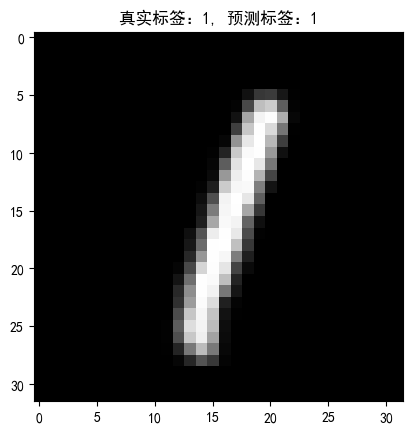

In [ ]:
# 从测试集中取一张图片  
test_image, test_label = test_dataset[5]  
  
test_image = test_image.unsqueeze(0)  

# 预测  
model.eval()  
with torch.no_grad():  
    output = model(test_image)  
    _, pred_label = torch.max(output, 1)  

# 画图显示结果  
plt.imshow(test_image.squeeze(), cmap="gray")  
plt.title(f"真实标签：{test_label}, 预测标签：{pred_label.item()}")  
plt.show()  